# CFAR 10

# Import Libraries

In [2]:
import numpy as np 
import pandas as pd 
from sklearn.utils.multiclass import unique_labels

import os

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [12]:
import tensorflow as tf
from tensorflow import keras

from keras.applications import VGG19,ResNet50

'Import the datagenerator to augment images'
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau

'Lastly import the final layers that will be added on top of the base model'
from tensorflow.keras.models import Sequential
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout

'Import to_categorical from the keras utils package to one hot encode the labels'
from keras.utils import to_categorical

# Import dataset


In [13]:
from keras.datasets import cifar10

In [14]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

# Print the dimensions of the datasets to make sure everything's good

In [15]:
print((x_train.shape,y_train.shape))
print((x_test.shape,y_test.shape))

((50000, 32, 32, 3), (50000, 1))
((10000, 32, 32, 3), (10000, 1))


In [16]:
x_train=x_train/255
x_test=x_test/255

# To Categorical

In [17]:
from tensorflow.keras.utils import to_categorical
y_cat_train=to_categorical(y_train,10)
y_cat_test=to_categorical(y_test,10)

## Steps for building a transfer learning model:

* Build the model (Base Model + Flatten + Dense)

* Check model summary

* Initialize Batch Size,Number of Epochs
Compile model

* Fit the model 

* Evaluate the model on test data

# Build the model

In [18]:
'''The first base model used is VGG19. The pretrained weights from the
 imagenet challenge are used'''
base_model_1 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),
                     classes=y_train.shape[1])

'''For the 2nd base model we will use Resnet 50 and compare the
 performance against the previous one.'''
base_model_2 = ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3),
                        classes=y_train.shape[1])


# Lets add the final layers to these base models where the actual classification is done in the dense layers

In [19]:
base_model_1.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [22]:
for layers in base_model_1.layers:
    layers.trainable=False

In [23]:
base_model_1.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [24]:
# Create a Sequential model
model_1 = Sequential()

# Add the base model (VGG19) to model_1
model_1.add(base_model_1)

# Flatten the output of the base model
model_1.add(Flatten())

# Add Dense layers along with activation and batch normalization
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(64, activation='relu'))

# Classification layer
model_1.add(Dense(10, activation='softmax'))

# Print model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 20098954 (76.67 MB)
Trainable params: 74570 (291.29 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


# Check final model summary

In [139]:
model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 10)                5130      
                                                                 
Total params: 20029514 (76.41 MB)
Trainable params: 20029514 (76.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Set Parameters

In [140]:
#Compile the model
#During model compiling the 3 main things we specify are loss function,optimizer and the metrics that need to be evaluated during the test and train processes.
#Lets start by using the SGD optimizer
#We will specify the loss as categoricl crossentropy since the labels are 1 hot encoded. IF we had integer labels,we'd have to use sparse categorical crossentropy as loss function.

model_1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# Early Stopping


In [141]:
import time

In [142]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=3)

In [143]:
start_time = time.time()

model_1.fit(x_train,y_cat_train,epochs=15,batch_size=64,
          validation_data=(x_test,y_cat_test),callbacks=[early_stop])


end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Epoch 1/15
   8/1563 [..............................] - ETA: 33:08 - loss: 2.7381 - accuracy: 0.1367

KeyboardInterrupt: 

# Check Metrics

In [22]:
metrics = pd.DataFrame(model_1.history.history)

<AxesSubplot:>

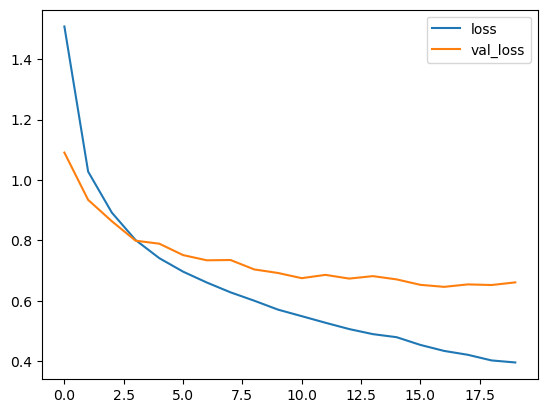

In [23]:
metrics[['loss', 'val_loss']].plot()

<AxesSubplot:>

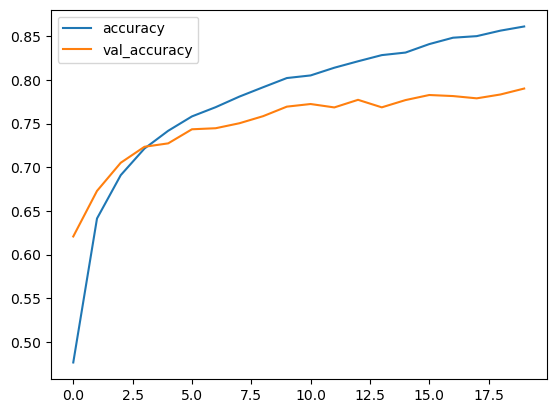

In [24]:
metrics[['accuracy', 'val_accuracy']].plot()

In [25]:
def plot_confusion_matrix(y_true, y_pred, classes):
  y_pred = [np.argmax(x, axis=0) for x in y_pred]
  y_true = [np.argmax(x, axis=0) for x in y_true]
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, xticklabels=classes, yticklabels=classes, annot=True)

In [26]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [27]:
y_pred=model_1.predict(x_test)

313/313 [==============================] - 13s 38ms/step


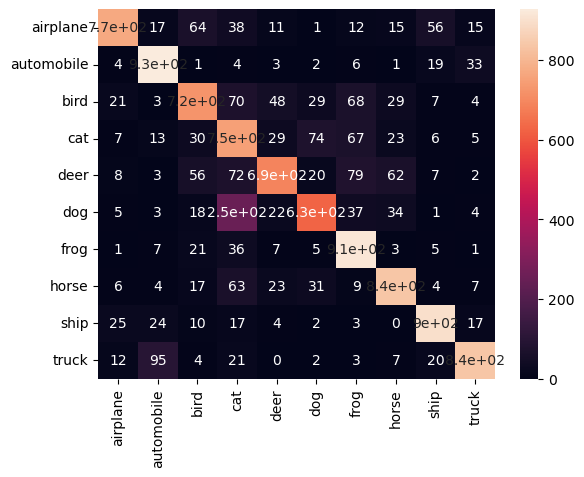

In [29]:
plot_confusion_matrix(y_true, y_pred, classes=class_names)

# Second Model

In [30]:
#Since we have already defined Resnet50 as base_model_2, let us build the sequential model.

model_2 = keras.Sequential()
#Add the Dense layers along with activation and batch normalization
model_2.add(base_model_2)
model_2.add(Flatten())

for layer in model_2.layers:
    layer.trainable = False

In [31]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 4000)              8196000   
                                                                 
 dense_6 (Dense)             (None, 2000)              8002000   
                                                                 
 dropout (Dropout)           (None, 2000)              0         
                                                                 
 dense_7 (Dense)             (None, 1000)              2001000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)             

In [32]:
#Compile the model 

model_2.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
model_2.fit(train_generator.flow(x_train,y_train,batch_size=batch_size),
                      epochs=epochs,
                      steps_per_epoch=x_train.shape[0]//batch_size,
                      validation_data=val_generator.flow(x_val,y_val,batch_size=batch_size),
                      validation_steps=x_test.shape[0]//batch_size,
                      callbacks=[lrr],verbose=1)

Epoch 1/20
273/273 [==============================] - 94s 305ms/step - loss: 1.6711 - accuracy: 0.4124 - val_loss: 2.8478 - val_accuracy: 0.3597 - lr: 0.0010
Epoch 2/20
273/273 [==============================] - 80s 293ms/step - loss: 1.0939 - accuracy: 0.6387 - val_loss: 1.2255 - val_accuracy: 0.6142 - lr: 0.0010
Epoch 3/20
273/273 [==============================] - 80s 293ms/step - loss: 0.9081 - accuracy: 0.7086 - val_loss: 1.0398 - val_accuracy: 0.6867 - lr: 0.0010
Epoch 4/20
273/273 [==============================] - 80s 293ms/step - loss: 0.9173 - accuracy: 0.7072 - val_loss: 1.5894 - val_accuracy: 0.5332 - lr: 0.0010
Epoch 5/20
273/273 [==============================] - 80s 293ms/step - loss: 0.8643 - accuracy: 0.7259 - val_loss: 5.5961 - val_accuracy: 0.3754 - lr: 0.0010
Epoch 6/20
273/273 [==============================] - 80s 293ms/step - loss: 0.9257 - accuracy: 0.6971 - val_loss: 1.3090 - val_accuracy: 0.5770 - lr: 0.0010
Epoch 7/20
273/273 [==============================] 

In [34]:
metrics = pd.DataFrame(model_2.history.history)

<AxesSubplot:>

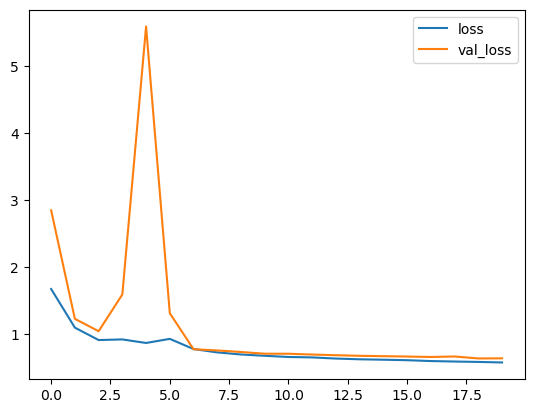

In [35]:
metrics[['loss', 'val_loss']].plot()

<AxesSubplot:>

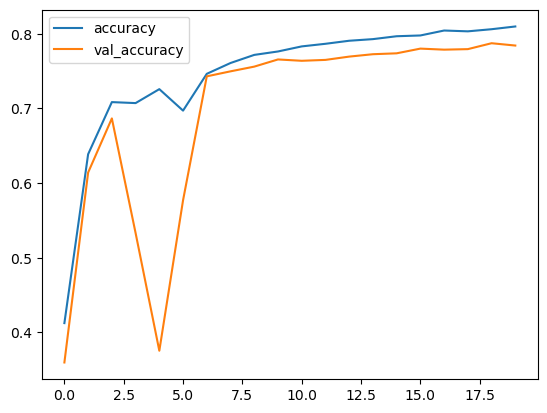

In [36]:
metrics[['accuracy', 'val_accuracy']].plot()

In [37]:
y_pred=model_2.predict(x_test)
y_true=y_test

313/313 [==============================] - 14s 39ms/step


In [38]:
model_2.evaluate(x_test, y_test)

313/313 [==============================] - 14s 42ms/step - loss: 0.6677 - accuracy: 0.7802


[0.667672872543335, 0.7802000045776367]

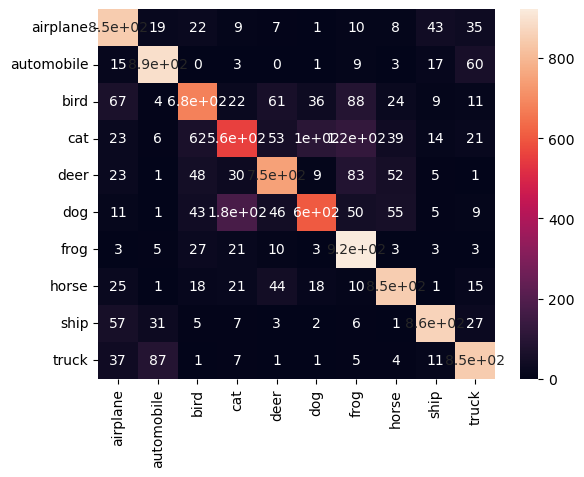

In [39]:
plot_confusion_matrix(y_true, y_pred, classes=class_names)

In [40]:
def predict_classes(model, image):
  image = image.reshape(1, 32, 32, 3)
  prediction = model.predict(image)
  return np.argmax(prediction, axis=1)

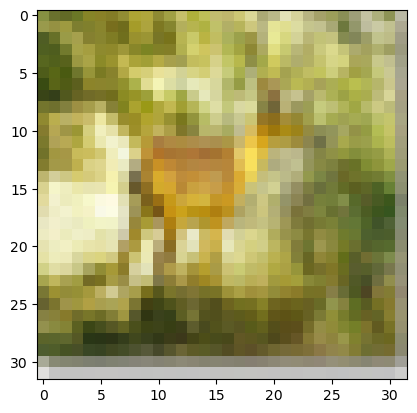

In [41]:
plt.imshow(x_test[500])

In [42]:
def get_class(y):
  return np.argmax(y, axis=0)

In [43]:
get_class(y_test[500])

4

In [44]:
predict_classes(model_1, x_test[500])

1/1 [==============================] - 1s 593ms/step


array([6], dtype=int64)

In [45]:
predict_classes(model_2, x_test[500])

1/1 [==============================] - 0s 488ms/step


array([4], dtype=int64)

In [46]:
from tensorflow.keras.models import load_model

In [47]:
model_1.save("model_sgd.h5")

In [48]:
model_2.save("model_adam.h5")

In [49]:
model_sgd= load_model("model_sgd.h5")
#model_adam=load_model("model_adam.h5") To bigg

In [50]:
fig_class=[ "airplane", "automobile","bird","cat","deer", "dog","frog","horse","ship","truck"]


CORRECT PREDICTIONS For Adam Optimizer


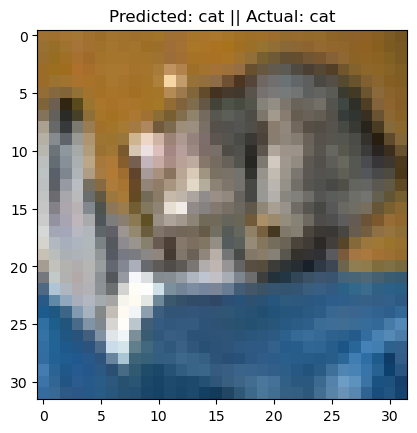

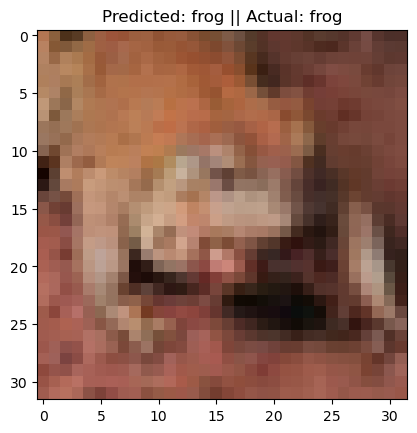

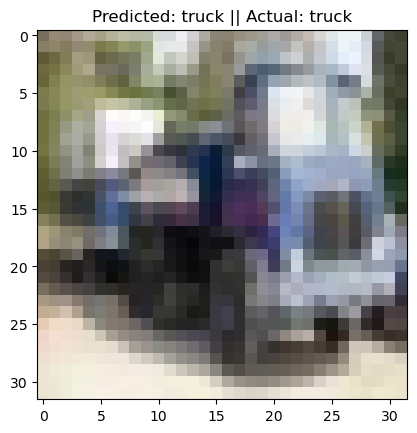

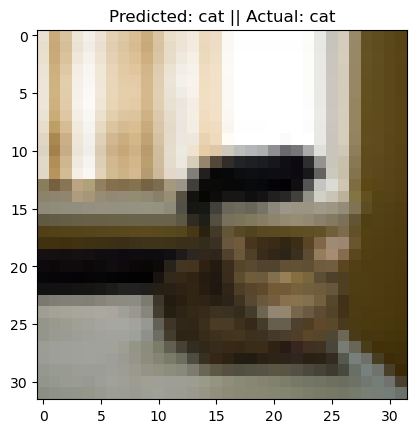

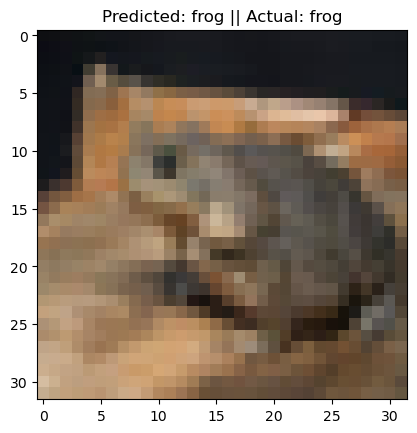

In [51]:
#Lets see which predictions were correct and which were incorrect
count=0
print("CORRECT PREDICTIONS For Adam Optimizer")

#Correct Predictions:
for i in range(0,10000):
    #to randomly check our sample data
    for_random=np.random.binomial(n=1,p=0.1,size=[1])
    
    #our test datas
   # test_image=test_image.resize((32,32))
    
    test_image=x_test[i].reshape(1,32,32,3)
    
    #gives back the prediction
    predict_image=model_2.predict(test_image,verbose=0)
    prediction_value=int(np.argmax(predict_image,axis=1))
    
    #plotting
    index=(np.where(y_test[i]==1))[0][0]
    if(index==prediction_value and for_random):
            plt.title(f"Predicted: {fig_class[prediction_value]} || Actual: {fig_class[index]}")
            plt.imshow(x_test[i])
            plt.show()
            count+=1
    if count == 5:
        break

CORRECT PREDICTIONS For Sgd Optimizer


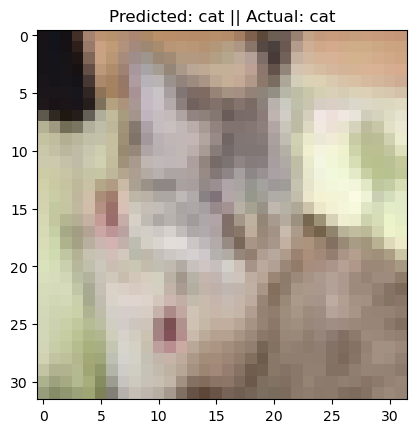

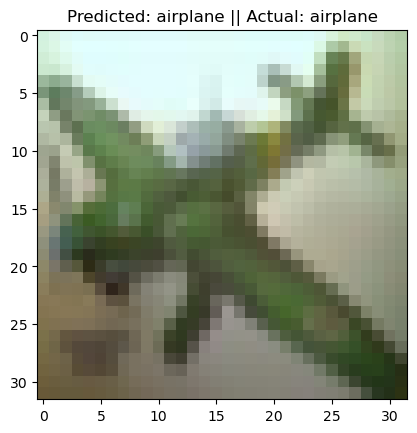

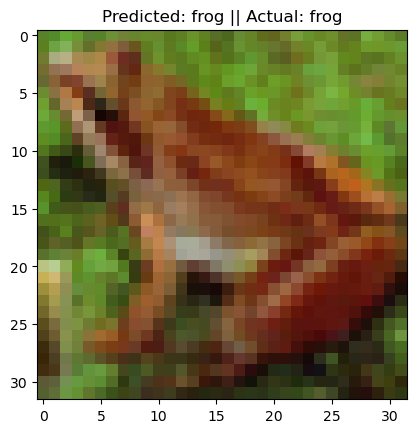

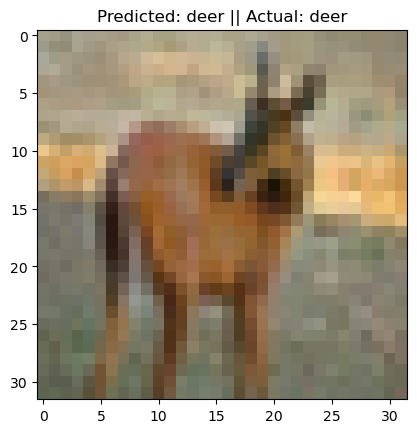

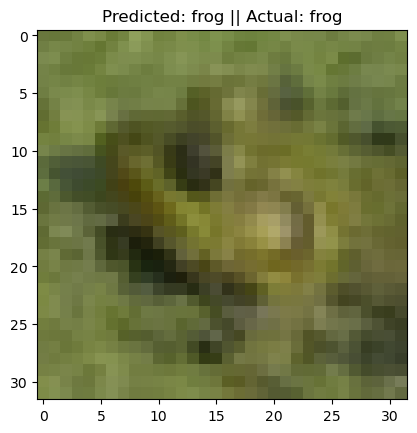

In [52]:
count=0
print("CORRECT PREDICTIONS For Sgd Optimizer")

#Correct Predictions:
for i in range(0,10000):
    #to randomly check our sample data
    for_random=np.random.binomial(n=1,p=0.1,size=[1])
    
    #our test datas
   # test_image=test_image.resize((32,32))
    
    test_image=x_test[i].reshape(1,32,32,3)
    
    #gives back the prediction
    predict_image=model_1.predict(test_image,verbose=0)
    prediction_value=int(np.argmax(predict_image,axis=1))
    
    #plotting
    index=(np.where(y_test[i]==1))[0][0]
    if(index==prediction_value and for_random):
            plt.title(f"Predicted: {fig_class[prediction_value]} || Actual: {fig_class[index]}")
            plt.imshow(x_test[i])
            plt.show()
            count+=1
    if count == 5:
        break

INCORRECT PREDICTIONS for adam


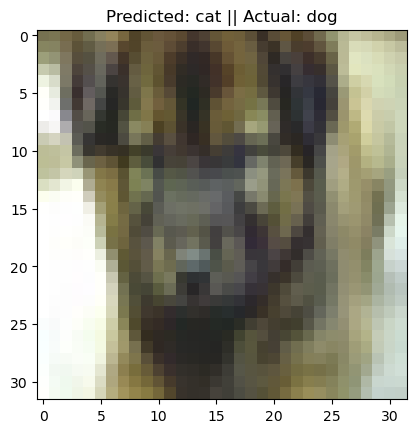

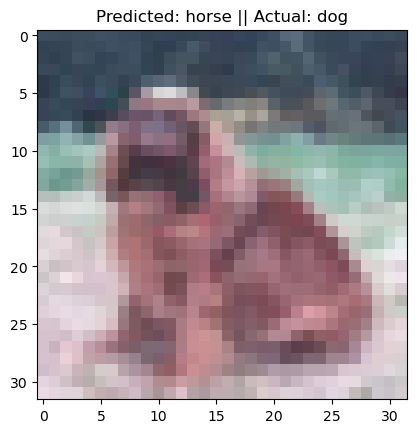

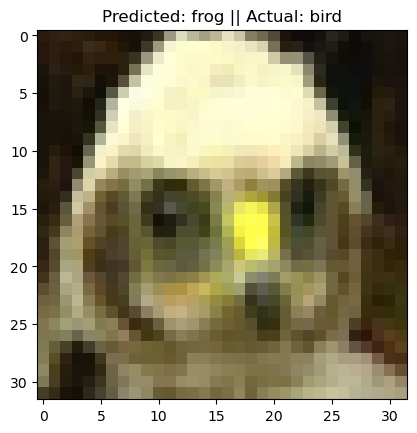

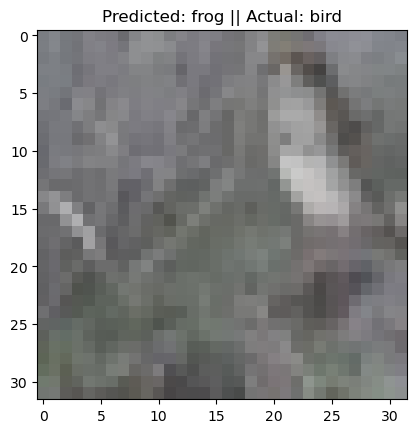

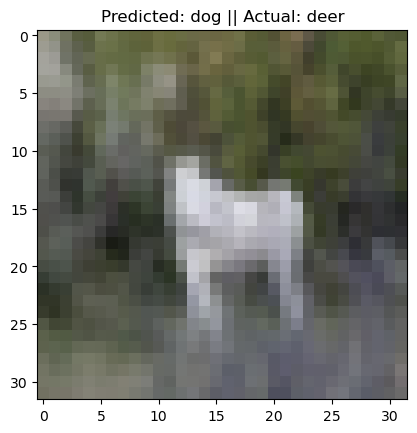

In [53]:
#Lets see which predictions were incorrect 
count=0
print("INCORRECT PREDICTIONS for adam")
#InCorrect Predictions:
for i in range(0,10000):
    #to randomly check our sample data
    for_random=np.random.binomial(n=1,p=0.1,size=[1])
    
    #our test datas
    test_image=x_test[i].reshape(1,32,32,3)
    #gives back the prediction
    predict_image=model_2.predict(test_image,verbose=0)
    prediction_value=np.argmax(predict_image,axis=1)
    index=(np.where(y_test[i]==1))[0][0]
    
    #plotting
    if(int(index)!=prediction_value and for_random):
            plt.title(f"Predicted: {fig_class[int(prediction_value)]} || Actual: {fig_class[index]}")
            plt.imshow(x_test[i])
            plt.show()
            count+=1
    if count == 5:
        break
            

INCORRECT PREDICTIONS For SGD Optimizer


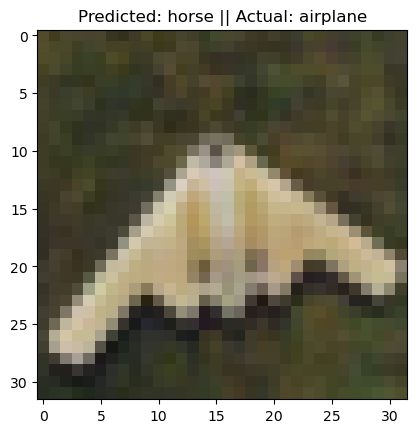

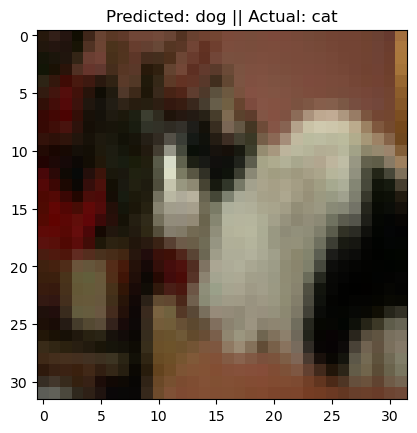

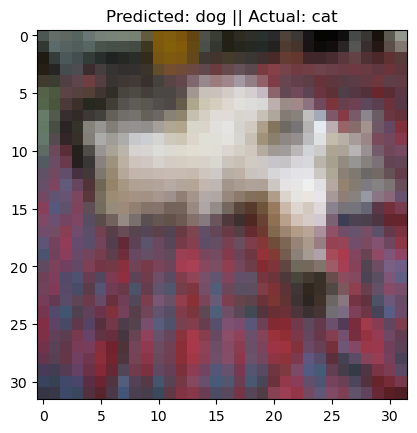

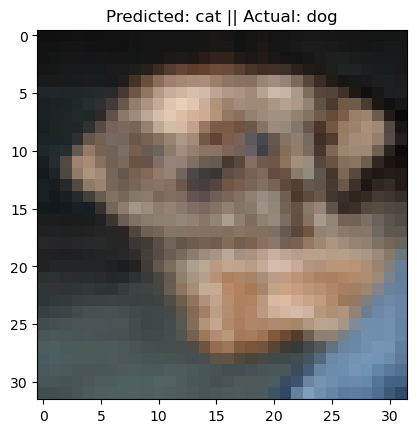

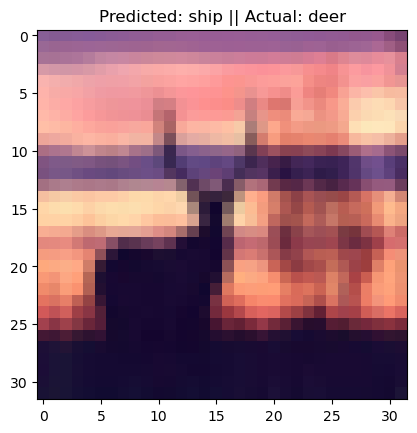

In [54]:
count=0
print("INCORRECT PREDICTIONS For SGD Optimizer")

#Correct Predictions:
for i in range(0,10000):
    #to randomly check our sample data
    for_random=np.random.binomial(n=1,p=0.1,size=[1])
    
    #our test datas
   # test_image=test_image.resize((32,32))
    
    test_image=x_test[i].reshape(1,32,32,3)
    
    #gives back the prediction
    predict_image=model_1.predict(test_image,verbose=0)
    prediction_value=int(np.argmax(predict_image,axis=1))
    
    #plotting
    index=(np.where(y_test[i]==1))[0][0]
    if(index!=prediction_value and for_random):
            plt.title(f"Predicted: {fig_class[prediction_value]} || Actual: {fig_class[index]}")
            plt.imshow(x_test[i])
            plt.show()
            count+=1
    if count == 5:
        break

In [55]:

#predicting on external pictures
from PIL import Image
import matplotlib.image as image
from numpy import array


In [56]:
#Predicting Exteranal Img with adam optimizer
def predict_externalImg_classes(image,index):
    #image_resize=image.resize((32,32))
    image_reshape=image.reshape(1,32,32,3)
    predict_image=model_2.predict(image_reshape,verbose=0)
    prediction_value=int(np.argmax(predict_image,axis=1))
    plt.title(f"Predicted: {fig_class[prediction_value]} || Actual: {fig_class[index]}")
    plt.imshow(image)
    plt.show()
    

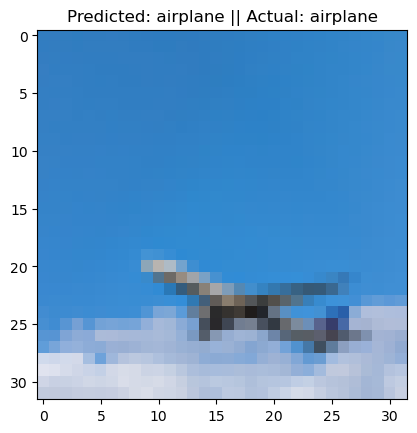

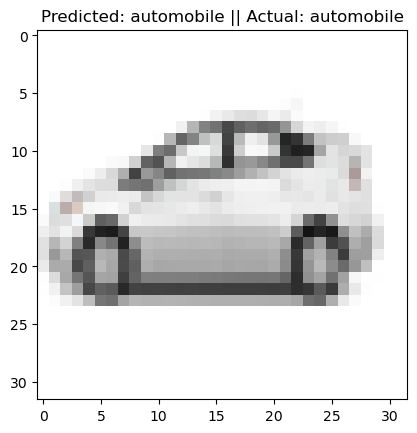

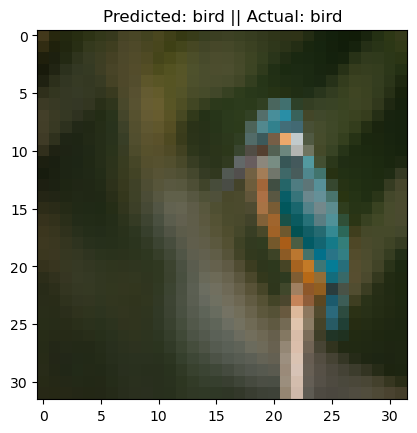

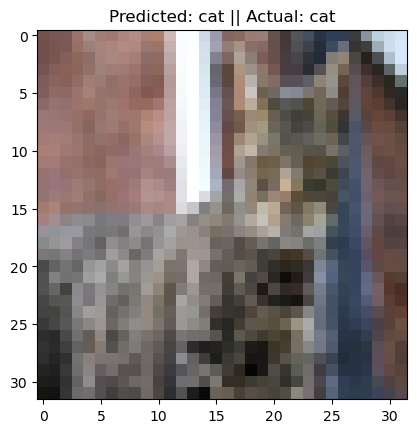

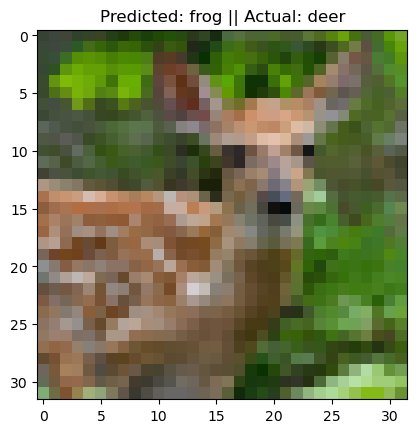

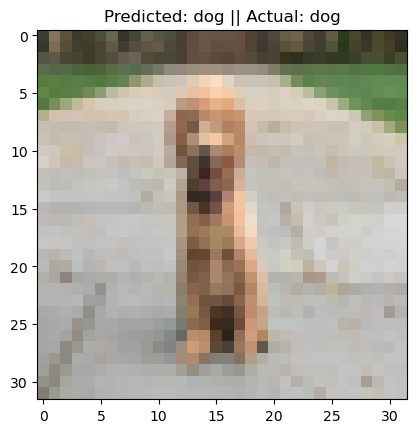

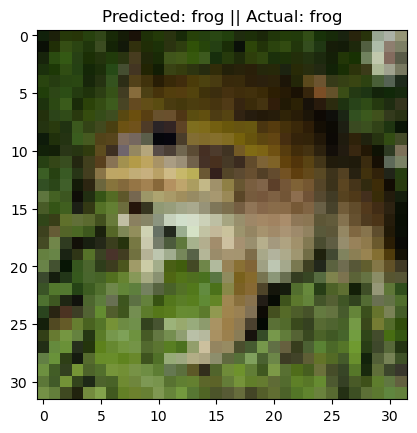

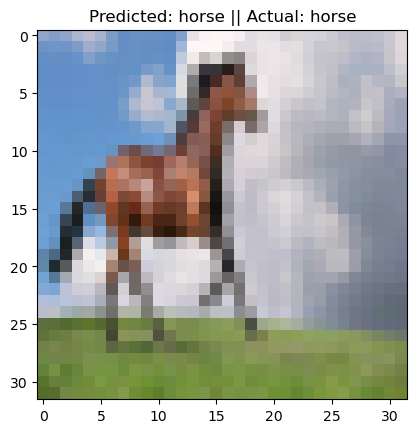

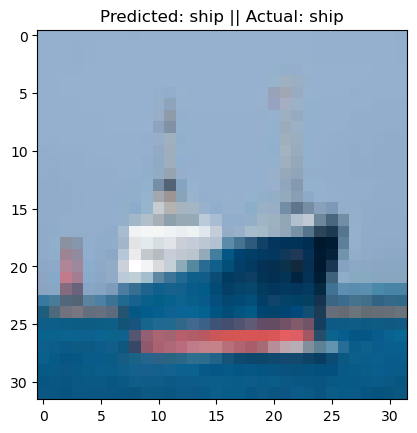

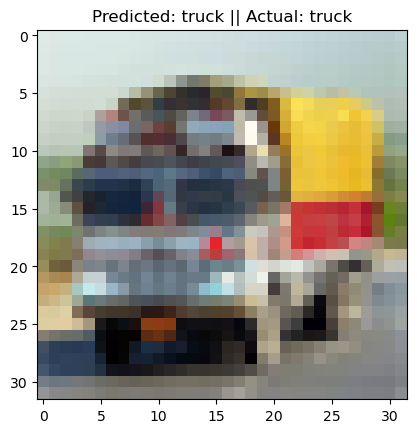

In [57]:
#Predicting External Image
for i in range (0,10):
    image=Image.open(rf"photo\{i}.jfif")
    image=image.resize((32,32))
    image_ar=array(image)
    predict_externalImg_classes(image_ar,i)

In [58]:
#Predicting Exteranal Img with sgd optimizer
def predict_externalImg_classes(image,index):
    #image_resize=image.resize((32,32))
    image_reshape=image.reshape(1,32,32,3)
    predict_image=model_1.predict(image_reshape,verbose=0)
    prediction_value=int(np.argmax(predict_image,axis=1))
    plt.title(f"Predicted: {fig_class[prediction_value]} || Actual: {fig_class[index]}")
    plt.imshow(image)
    plt.show()
    

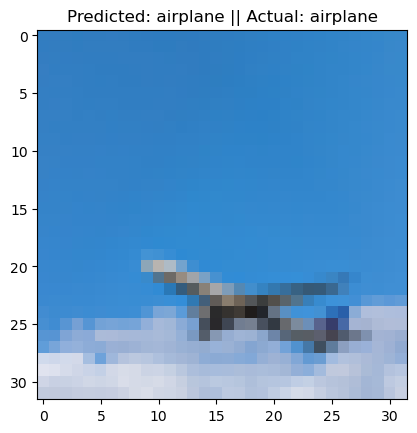

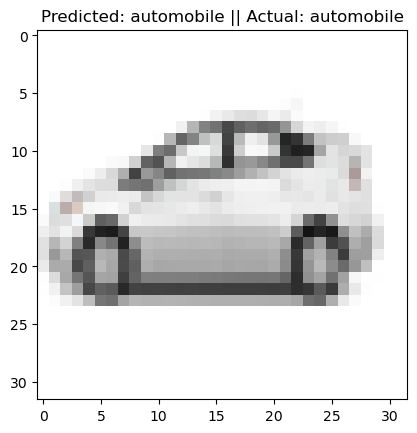

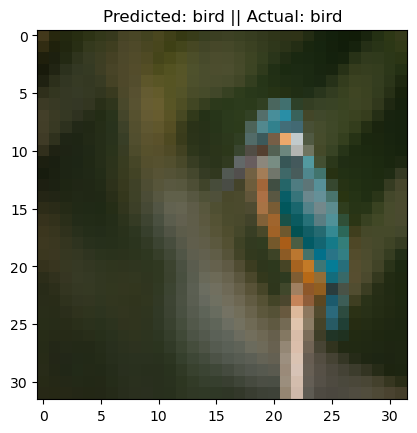

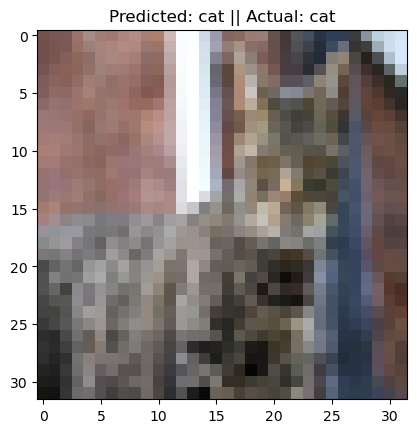

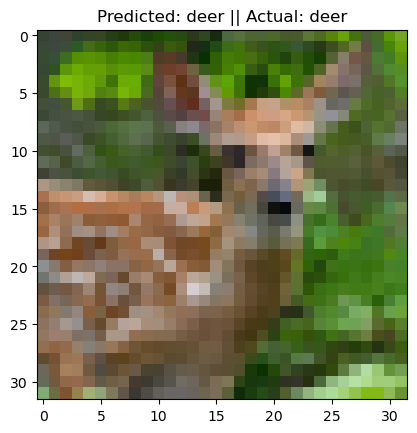

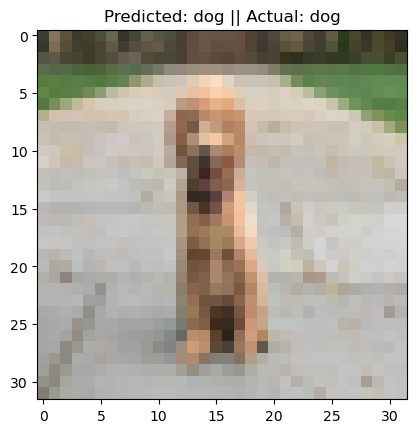

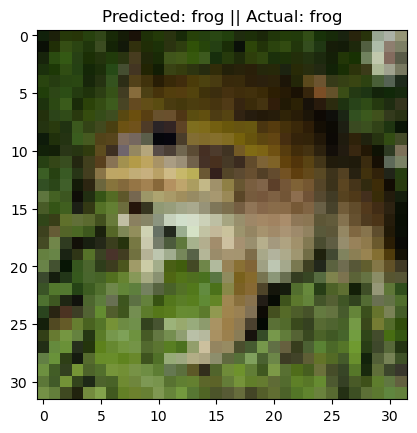

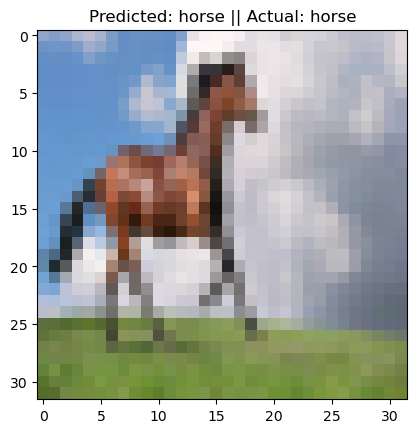

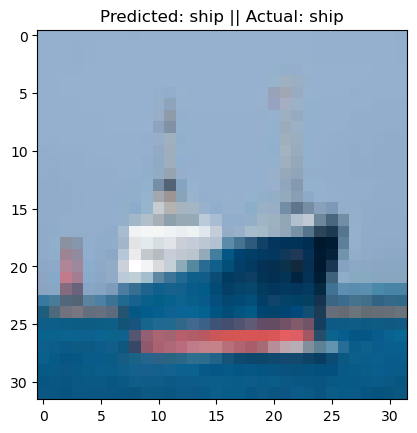

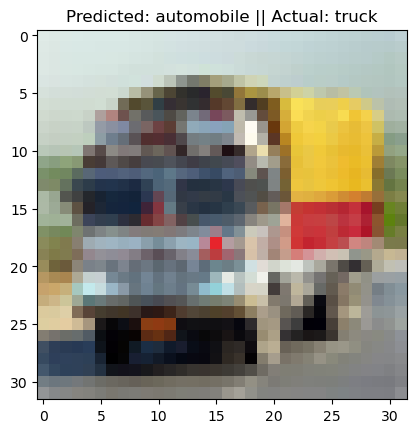

In [59]:
#Predicting External Image
for i in range (0,10):
    image=Image.open(rf"photo\{i}.jfif")
    image=image.resize((32,32))
    image_ar=array(image)
    predict_externalImg_classes(image_ar,i)